In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


To train the UCM on synthetic data, run:

python3 HDC.py --checkpoint_dir /scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/ --data_path /scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/ --synthetic --synthetic_name synthetic_nonpoisson --cv -1 --batch_size 5000 --max_epochs 3000 --bin_size 160 --likelihood U-eq-2 --mapping svgp-64 --x_mode hd --lr 1e-2 --jitter 1e-4 --gpu 0

# Analysis of UCM fit on synthetic data

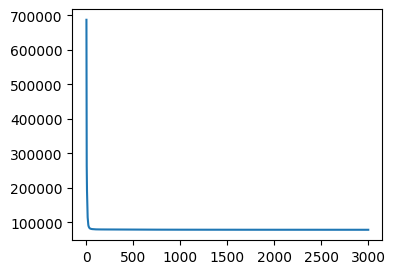

In [2]:
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'


#dataset_dict = HDC.get_synthetic_data('synthetic_poisson', data_dir)
#dataset_dict = HDC.get_synthetic_data('synthetic_nonpoisson', data_dir)
#dataset_dict = HDC.get_synthetic_data('synthetic_uniform', data_dir)
#dataset_dict = HDC.get_synthetic_data('synthetic_nonpoisson_2', data_dir)
dataset_dict = HDC.get_synthetic_data('synthetic_negbinomial', data_dir)

model_dict = {
                'seed': 123, 
                'll_mode': 'U-eq-2',  # stands for universal count model with exponential-quadratic expansion and C = 2
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }

checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run=-1

modelfit, training_results, fit_set, validation_set = lib.models.load_model(
                    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
                    delay, cv_run, batch_size, gpu_dev
                )

#ll = lib.helper.RG_pred_ll(
#    modelfit, validation_set, neuron_group=None, ll_mode='MC', 
#    ll_samples=1, cov_samples=1, beta=0.0
#)

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(training_results['training_loss'])

In [3]:
neurons = dataset_dict['neurons']

hd_sweep = torch.linspace(0, 2*np.pi, 100)

covariates = hd_sweep[None, None, :, None]

with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(neurons)), MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

print(P_mc.shape)

K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

torch.Size([30, 5, 100, 291])


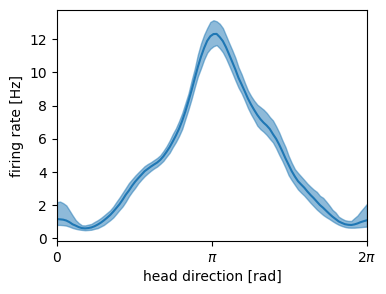

In [4]:
fig, ax = plt.subplots(figsize=(4,3))

lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
ne = 2  # select neuron to plot

line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('firing rate [Hz]')
ax.set_xlabel('head direction [rad]')
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()


In [8]:
[tc_mean] = utils.signal.percentiles_from_samples(hd_rate, [0.5])
[tc_FF] = utils.signal.percentiles_from_samples(hd_FF, [0.5])
[tc_var] = utils.signal.percentiles_from_samples(hd_var, [0.5])

grad = torch.gradient(torch.nan_to_num(torch.log(P_mc), neginf=0.0), dim=2)
grad = grad[0]

[fisher] = utils.signal.percentiles_from_samples((grad**2 * P_mc).sum(-1), [0.5])

[fisher_poisson] = utils.signal.percentiles_from_samples(torch.gradient(hd_rate, dim=2)[0]**2/  hd_rate, [0.5])
fisher_poisson *= dataset_dict['tbin']


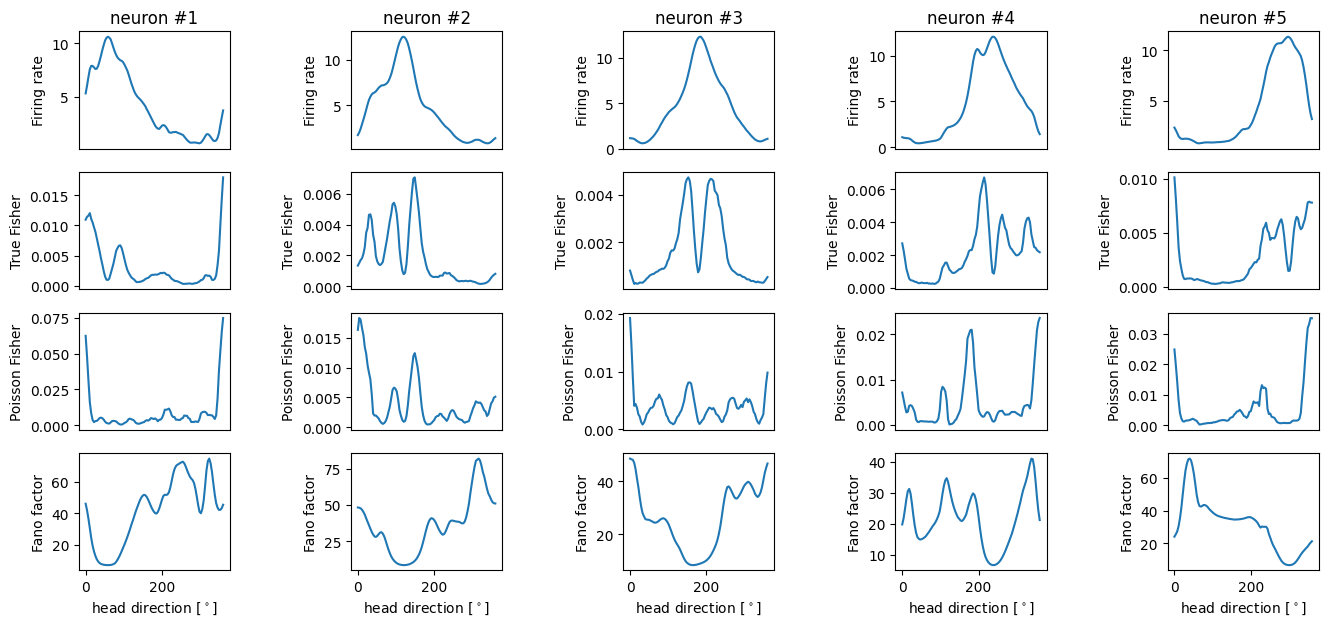

In [6]:
fig = plt.figure(figsize=(16,7))
spec = gridspec.GridSpec(1, 5, figure=fig, wspace=0.8)

angles = np.linspace(0, 360, hd_sweep.shape[-1])

for ne in np.arange(5):
    
    gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=spec[ne])

    ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3])]

    ax[0].plot(angles, tc_mean[ne, :])
    ax[1].plot(angles, fisher[ne, :])
    ax[2].plot(angles, fisher_poisson[ne, :])
    ax[3].plot(angles, tc_FF[ne, :])
    
    ax[0].set_title(f'neuron #{ne+1}')
    ax[0].set_ylabel('Firing rate')
    ax[1].set_ylabel('True Fisher')
    ax[2].set_ylabel('Poisson Fisher')
    ax[3].set_ylabel('Fano factor')

    for i in range(3):
        ax[i].set_xticklabels([])
        ax[i].set_xticks([])

    ax[3].set_xlabel('head direction [$^\circ$]')
    


plt.tight_layout()

Text(0.5, 0, 'head direction [$^\\circ$]')

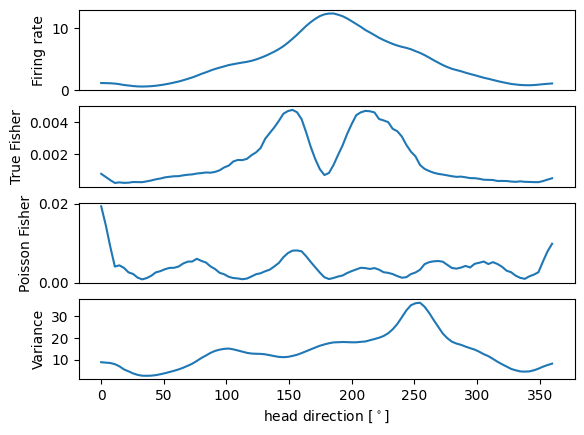

In [9]:
fig, ax = plt.subplots(4, 1)

ax[0].plot(angles, tc_mean[2, :])
ax[1].plot(angles, fisher[2, :])
ax[2].plot(angles, fisher_poisson[2, :])
ax[3].plot(angles, tc_var[2, :])

ax[0].set_ylabel('Firing rate')
ax[1].set_ylabel('True Fisher')
ax[2].set_ylabel('Poisson Fisher')
ax[3].set_ylabel('Variance')

for i in range(3):
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])

ax[3].set_xlabel('head direction [$^\circ$]')